## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df_1 = df.loc[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')]
df_2 = df.loc[(df['group'] != 'treatment') & (df['landing_page'] == 'new_page')]

df_1['user_id'].count() + df_2['user_id'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().values.sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df[((df.group == 'treatment') & (df.landing_page == 'new_page')) | ((df.group == 'control') & (df.landing_page == 'old_page'))]
df2.describe()

,user_id,converted
count,290585.000000,290585.000000
mean,788004.825246,0.119597
std,91224.582639,0.324490
min,630000.000000,0.000000
25%,709035.000000,0.000000
50%,787995.000000,0.000000
75%,866956.000000,0.000000
max,945999.000000,1.000000


In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df_duplicate = df2.loc[(df2['user_id'].duplicated() == True)]
df_duplicate

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df_duplicate.info

<bound method DataFrame.info of       user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0>

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
prob1 = df2.loc[df2['converted'] == 1].shape[0] / df2.shape[0]
prob1

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
prob2 = df2.loc[(df2['converted'] == 1) & (df2['group'] == 'control')].shape[0] / df2.loc[df2['group'] == 'control'].shape[0]
prob2

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
prob3 = df2.loc[(df2['converted'] == 1) & (df2['group'] == 'treatment')].shape[0] / df2.loc[df2['group'] == 'treatment'].shape[0]
prob3

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
prob4 = df2.loc[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]
prob4

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**The conversion rate for the control group was marginally higher than the treatment group (0.2%)**

**The probability a user was served a new page is 50% which means that the conversion rate is unlikely to be different with more occurences**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null Hypothesis: Old page has a better conversion rate**

**Alternative Hypothesis: New page has a better conversion rate at a Type 1 error rate of 5%**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [18]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Drawing samples from a binomial distribution (p_new)
new_page_converted= np.random.binomial(1, p=p_new, size=n_new) 
new_page_converted

array([0, 0, 1, ..., 1, 0, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Drawing samples from a binomial distribution (p_old)  
old_page_converted= np.random.binomial(1, p=p_old, size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff=new_page_converted.mean()-old_page_converted.mean()
diff

0.00036951752054895093

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

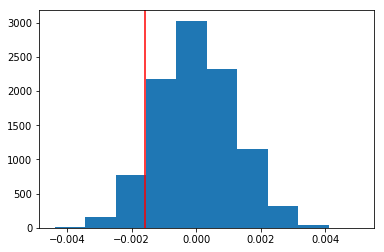

In [26]:
plt.hist(p_diffs)

# Calculate difference between experiment and control conversions
l = prob3 - prob2

plt.axvline(l, color='red') 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
act_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
act_diff

-0.0014795997940775518

In [28]:
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00134029, -0.00052521,  0.00160863, ..., -0.00086957,
        0.00089976,  0.00107162])

In [29]:
# proportion of p_diffs greater than the actual difference
(act_diff < p_diffs).mean()

0.89300000000000002

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This value is called the p-value which is the probability of finding the observed, or more extreme, results when the null hypothesis (H0) of a study question is true.** 

**In this case, the new page doesn't have better conversion rates than the old page because the value 0.895 is much higher than the alpha, 0.05.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [30]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]
convert_old

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [31]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(p_value)
print(z_score)

0.905058312759
1.31092419842


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [32]:
from  scipy.stats  import norm

# Check z-score significance
print(norm.cdf(z_score))

# taking a 95% confidence level for the single-sided test 
print(norm.ppf(1-(0.05)))

0.905058312759
1.64485362695


**The z-score we have is smaller than the value of 1.64485362695 (one-tail test) which suggests that the null can't be rejected. Also the p-value is higher than the alpha 0.05 which shows that the new page does not convert better than the older page (can't reject the null). Despite the value being slightly different from parts j and k, it still suggests that there is no statistically significant difference between the new and the old page, therefore we agree with the findings in parts j and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept']=1

#create a dummy variable column for which page the user received
df2= df2.join(pd.get_dummies(df2['landing_page']))

df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
import statsmodels.api as sm

logit1 = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:09:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value here is 0.190** 

**It differs from the value in Part2 because the tests of the regression model assumes an intercept and  because the last test was two-sided (one-sided test performed in Part2).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Including other explanatory variables would increase the reliability of our results as it improves the r-squared values, however, adding additional variables in our regression model may also lead to multicollinearity which happens when a correlation exists between the explanatory variables. Everytime we include a predictor variable the sample size has to change accordingly to make sure that the significant predictor in the new model is in line with the significance level.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')

#Merging 2 data frames with index as user_id
df_new = df2.merge(countries_df, on ='user_id', how='left')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


In [37]:
# Create dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1


In [38]:
df_new['intercept'] = 1

#Create LRM for converted and country (baseline: CA and old page) 
logit2 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
result = logit2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:               2.323e-05
Time:                        13:09:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
#Create a new interaction variable 
df_new['UK_new_page'] = df_new['new_page']* df_new['UK']
df_new['US_new_page'] = df_new['new_page']* df_new['US']

#Regression summary between new page and country variable using previous dummies
logit3 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
results = logit3.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 06 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        13:09:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [40]:
#Exponantiate results from last summary 
np.exp(results.params)

intercept      0.134794
new_page       0.934776
UK_new_page    1.081428
US_new_page    1.048001
UK             1.011854
US             1.017682
dtype: float64

Interpretation of results:

The country is not significant on the conversion rate when taking into consideration the landing page. This is proven in the last Logit Regression model where it is evident how all variables except for the intercept are not statistically significant since the p-value is larger than 0.05. The z-value for these variables is also not large enough to be used for predicting the conversion rate.

From the exponantial values the conversion rate for UK new page users is likely to happen 1.08 times more than CA new page users, holding all other variables constant. The rate for US new page users is slightly less at 1.05 times.

Overall conversion by country (regardless of landing page) is likely to happen 1.18% and 1.76% for the UK and the US over CA given that other variables remain unchanged.

## Conclusions

**From the given data I conclude that the old page is better than the new one, and therefore the alternative hypothesis is not accepted.**

**In the last regression model we notice a higher p-value for the US which shows that US users are more likely to convert than Canadians. Having said that, more data is required to reject the null hypothesis.** 

In [41]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0